# Tutorial and Sample Code for Balancing a Pole on a Cart

## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [2]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.02322467  0.04607284 -0.02344057  0.0083904 ]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.02230321 -0.14870523 -0.02327276  0.29358634]
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [ ]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

### My agent implementation

Importing dependancies

In [ ]:
import os
import tensorflow as tf
from keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential

from collections import deque
from statistics import mean
import random

The environment is made of a continous state space and cannot be easily represented using a Q-value table. Thus a neural network is used similar to the lecture on Reinforcement Learning to replace the table.

Below is my implementation of Deep Q-Network and the Agent

In [ ]:
class DeepQNetwork(object):
    def __init__(self, input_shape, action_space, fully_connected_layers = (64, 32),
                 chkpt_dir='tmp/dqn'):
        self.input_shape = input_shape
        self.action_space = action_space # array of possible actions
        self.num_actions = len(action_space) # number of possible actions
        self.fully_connected_layers = fully_connected_layers # num of neurons of each hidden layer

        # Learning rate, optimizer, and loss function for the network
        self.lr = 0.00025
        self.optimzer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.loss = tf.keras.losses.MeanSquaredError()

    # Helper function to create Dense layers in network
    def dense_layer(self, num_units):
        # num_units: number of neurons in the layer
        return Dense(
            num_units,
            activation = tf.keras.activations.relu,
            kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2.0))

    def build_network(self):
        # network is made of input layer, hidden layers, and output layer
        model = Sequential()
        # add initial input layer
        model.add(Input(self.input_shape))

        # Network needs dense layers followed by a final layer
        # with 'num_actions' neurons to generate the actual q_value as output
        for i in range(len(self.fully_connected_layers)):
            model.add(self.dense_layer(self.fully_connected_layers[i]))

        # final output layer
        # kernel_initializer & bias_initializer: initial parameters of network
        output_layer = Dense(
            self.num_actions,
            activation=None, # want the actual values
            kernel_initializer=tf.keras.initializers.RandomUniform(
                minval=-0.03, maxval=0.03),
            bias_initializer=tf.keras.initializers.RandomUniform(
                minval=-0.01, maxval=0.01)
            )
        model.add(output_layer)

        # final complete network with all layers
        model.compile(loss = self.loss, optimizer = self.optimzer,
                      metrics=['accuracy'])

        # model.summary() # uncomment to check how the model is set
        return model

In [ ]:
DeepQNetwork((4,),[0,1]).build_network().summary() # to cfm that implementation is working

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2466 (9.63 KB)
Trainable params: 2466 (9.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class DQNAgent(object):
    def __init__(self, action_space, epsilon = 1, gamma = 0.95):
        self.name = 'dqn.keras' # name of model save file

        self.state_size = env.observation_space.shape[0] # length of observation
        self.action_space = action_space # list of valid actions
        self.num_actions = len(action_space) # number of valid actions

        self.epsilon = epsilon # for determining random actions
        self.min_epsilon = 0.05 # low value so that agent can still explore but not affect
        self.gamma = gamma # discount future rewards
        self.train_start = 256 # trains when agent has enough experience
        self.retrained = False # track changes to the network for saving

        self.max_mem = 512 # total number of states to remember
        self.batch_size = 64 # number of states to use when learning
        self.memory = deque(maxlen=self.max_mem) # to remember experiences

        # the model that the agent uses
        self.dq_network = DeepQNetwork((self.state_size,), self.action_space).build_network()

        # a queue that records the cumulative rewards of agent
        self.output_results = deque(maxlen=100)

    def save_state(self, env_output):
        # saves state in memory of agent
        # state, action, reward, next_state, done
        self.memory.append(env_output)

        if len(self.memory) > self.train_start:
            self.decay_epsilon()

    def decay_epsilon(self):
        # helper function to reduce random action chance slowly
        if self.epsilon > self.min_epsilon:
            self.epsilon *= 0.99
        elif self.epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon

    def choose(self, curr_state):
        # returns action to take
        # take rand actions at the start,
        # decay epsilon to eventually take greedy actions based on model
        rand = np.random.random()
        if rand < self.epsilon:
            # random action
            action = np.random.choice(self.action_space)
        else:
            # greedy action
            # get q values from network using current state as input
            actions = self.dq_network.predict(curr_state, verbose=0)
            action = np.argmax(actions)
        return action

    def learn(self):
        # function for agent learning from experience

        # continue to observe and not learn if not enough experiences in memory
        if len(self.memory) < self.train_start : return

        self.retrained = True # to remember to save this retrained model

        # sample a batch from experience
        batch = random.sample(self.memory,
                              min(self.batch_size, len(self.memory)))

        # prepare variables and initialise the values to 0
        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        # split data to use more easily
        for i in range(self.batch_size):
            states[i] = batch[i][0]
            actions.append(batch[i][1])
            rewards.append(batch[i][2])
            next_states[i] = batch[i][3]
            dones.append(batch[i][4])

        # q value prediction for entire batch
        # verbose=0 to stop progress bar printing
        q = self.dq_network.predict(states, verbose=0)
        q_next = self.dq_network.predict(next_states, verbose=0)

        # calculate Q values
        for i in range(self.batch_size):
            if dones[i]:
                # terminal state
                q[i][actions[i]] = rewards[i]
            else:
                # chooses the max Q value among next actions
                # new Q = current_reward + discounted max future reward
                q[i][actions[i]] = rewards[i] + self.gamma * (np.amax(q_next[i]))

        # retrain model on the batch
        self.dq_network.fit(states, q, batch_size=self.batch_size, verbose=0)

    def load(self, name = None):
        # helper to load model
        name = self.name if name is None else name
        self.dq_network = load_model(name) # load model from file
        self.dq_network.summary() # print out how the model looks like

    def save(self, name = None):
        # helper to save model
        name = self.name if name is None else name
        self.dq_network.save(name)

    def run_agent(self, num_episodes, training = True, resume = False):
        # wrapper for actual function so that if i interrupt early, it will save
        try:
            self._run_agent(num_episodes, training, resume)
        except KeyboardInterrupt:
            print("quitting early...")
            if training:
                print("saving model as", self.name)
                self.save()

    def _run_agent(self, num_episodes, training = True, resume = False):
        # training == False: runs agent without learning
        # resume == True: loads agent to continue from prev
        if not training or resume:
            print("loading model", self.name)
            self.load()

        print("starting agent.")
        for e in range(num_episodes):
            state = env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False # if terminal state
            i = 0 # current reward count

            # while agent still alive, need to:
            # make decision
            # simulate action
            # save experience
            # try to learn
            while not done:
                action = self.choose(state) # decide

                next_state, reward, done, _ = env.step(action) # do action
                next_state = np.reshape(next_state, [1, self.state_size]) # process data for later

                i += 1
                if done: # print stuff when episode over
                    print("episode: {}/{}, score: {}, epsilon: {:.2f}".format(
                        e, num_episodes, i, self.epsilon)
                    )

                    self.output_results.append(i) # append current result

                    if training:
                        # will exit early if the current model is good enough

                        # side effect of loading already trained model is it
                        # will quit before reaching task 2 requirement of 100 episodes
                        curr_mean = mean(self.output_results)
                        print("ave cumulative result:",curr_mean)
                        # task 2 wants > 195, choose 250 for some margin of error
                        if curr_mean > 250:
                            print("agent is good enough, saving as final-dqn.keras")
                            self.save("final-dqn.keras")
                            return # forgot to add this when making the training output below

                # if user wants agent to train
                if training:
                    # print("training agent from exp...")
                    # save experience
                    self.save_state(
                        (state, action, reward, next_state, done)
                        )
                    # learn from exp
                    self.learn()

                # advance to next state
                state = next_state

            # if training is true, save model at end of episode if updated
            if training and self.retrained:
                print("Saved trained model as", self.name)
                self.save()
                self.retrained = False

### Code to set and train agent from scratch

In [ ]:
# training agent from scratch

myagent = DQNAgent([0,1])
myagent.run_agent(500)

starting agent.
episode: 0/500, score: 25, epsilon: 1.00
ave cumulative result: 25
episode: 1/500, score: 12, epsilon: 1.00
ave cumulative result: 18.5
episode: 2/500, score: 25, epsilon: 1.00
ave cumulative result: 20.666666666666668
episode: 3/500, score: 21, epsilon: 1.00
ave cumulative result: 20.75
episode: 4/500, score: 15, epsilon: 1.00
ave cumulative result: 19.6
episode: 5/500, score: 23, epsilon: 1.00
ave cumulative result: 20.166666666666668
episode: 6/500, score: 30, epsilon: 1.00
ave cumulative result: 21.571428571428573
episode: 7/500, score: 22, epsilon: 1.00
ave cumulative result: 21.625
episode: 8/500, score: 13, epsilon: 1.00
ave cumulative result: 20.666666666666668
episode: 9/500, score: 43, epsilon: 1.00
ave cumulative result: 22.9
episode: 10/500, score: 13, epsilon: 1.00
ave cumulative result: 22
episode: 11/500, score: 13, epsilon: 1.00
ave cumulative result: 21.25
episode: 12/500, score: 15, epsilon: 0.88
ave cumulative result: 20.76923076923077
Saved trained m

### Task 1

For Task 1, we can show the observation and chosen action below:

In [ ]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.01532139 -0.00978187  0.02280537 -0.02991185]
Chosen action: 1


#### Testing my agent

In [ ]:
# set agent for testing from save file
filename = "my_model.h5"

test_agent = DQNAgent([0,1], epsilon = 0.05)
test_agent.name = filename
test_agent.load(filename)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2466 (9.63 KB)
Trainable params: 2466 (9.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
observation = env.reset()
observation = np.reshape(observation, [1, 4]) # need to preprocess input for agent

action = test_agent.choose(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [[-0.04524413  0.00335797 -0.00227564 -0.04814879]]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

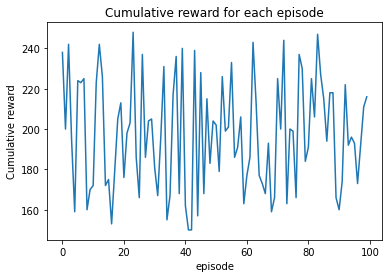

In [ ]:
episode_results = np.random.randint(150, 250, size=100)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 197.43
Is my agent good enough? True


#### Plotting my agent's results

Run test agent for plotting results later

In [ ]:
test_agent.run_agent(100, training = False)

loading model dqn.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2466 (9.63 KB)
Trainable params: 2466 (9.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
starting agent.
episode: 0/100, score: 500, epsilon: 0.05
episode: 1/100, score: 500, epsilon: 0.05
episode: 2/100, score: 500, epsilon: 0.05
episode: 3/100, score: 500, epsilon: 0.05
episode: 4/100, score: 500, epsilon: 0.05
episode: 5/100, score: 500, epsilon:

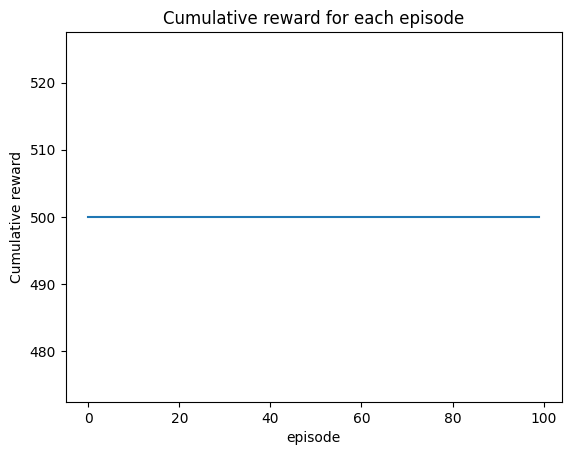

Average cumulative reward: 500
Is my agent good enough? True


In [ ]:
agent_results = test_agent.output_results
plt.plot(agent_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()
print("Average cumulative reward:", mean(agent_results))
print("Is my agent good enough?", mean(agent_results) > 195)

In [ ]:
# see results just to check
print(test_agent.output_results)

deque([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500], maxlen=100)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()

    observation = np.reshape(observation, [1, 4]) # need to preprocess input for agent
    #your agent goes here
    action = test_agent.choose(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
